In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
%matplotlib inline

In [2]:
# sin波の系列データをランダムに生成する
def generate_sin_wave(x,positive=True):
    a = random.randint(1,8)
    noise = np.random.randn()
    label = 0
    if not positive:
        a = a*(-1)
        label = 1
    return a*np.sin(x)+noise,label

In [3]:
# cos波の系列データをランダムに生成する
def generate_cos_wave(x,positive=True):
    a = random.randint(1,8)
    noise = np.random.randn()
    label = 2
    if not positive:
        a = a*(-1)
        label = 3
    return a*np.cos(x)+noise,label

In [4]:
def generate_dataset(each_data_num,one_hot_label=True):
    x = np.linspace(-np.pi, np.pi,20)
    wave_datas = []
    label_datas = []
    for i in range(each_data_num):
        s_positive_data,s_positive_label = generate_sin_wave(x,positive=True)
        s_negative_data,s_negative_label = generate_sin_wave(x,positive=False)
        c_positive_data,c_positive_label = generate_cos_wave(x,positive=True)
        c_negative_data,c_negative_label = generate_cos_wave(x,positive=False)
        
        wave_datas.append(s_positive_data),label_datas.append(s_positive_label)
        wave_datas.append(s_negative_data),label_datas.append(s_negative_label)
        wave_datas.append(c_positive_data),label_datas.append(c_positive_label)
        wave_datas.append(c_negative_data),label_datas.append(c_negative_label)
    if one_hot_label:
        T = np.zeros((4*each_data_num, 4))
        for idx, row in enumerate(T):
            row[label_datas[idx]] = 1
        return np.array(wave_datas),np.array(T)
    
    return np.array(wave_datas),np.array(label_datas)

In [5]:
# 各クラス 訓練 : 800個, テスト : 300個 ずつ系列データを生成する
x_train, t_train = generate_dataset(800,one_hot_label=True)
x_test, t_test = generate_dataset(300,one_hot_label=True)

In [6]:
x_train = x_train.reshape(3200,20,1)
x_test = x_test.reshape(1200,20,1)

In [7]:
input_size = 1
max_time = x_train.shape[1]

# max_time : 系列データの長さ、input_size : 入力のデータ数
X = tf.placeholder(tf.float32, shape=[None,max_time,input_size],name="input")
t = tf.placeholder(tf.float32, shape=[None, 4])

In [9]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=100)
# outputs は  [ミニバッチのサイズ、系列データの長さ、出力のデータ数] で出力される
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32, time_major=False)
outputs = tf.transpose(outputs, perm=[1, 0, 2])

In [10]:
W = tf.Variable(tf.truncated_normal([100,4], stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[4]))
# 後ろのデータ(最終時系列)から引っ張ってくる
p = tf.nn.softmax(tf.nn.xw_plus_b(outputs[-1],W,b),name="output")

In [11]:
### 損失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=p))

### 学習op
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)

### モデルの評価
correct_prediction = tf.equal(tf.argmax(p,1), tf.argmax(t,1))
# 精度
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
i = 0
batch_size = 30

for i in range(5000):
    batch_mask = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    sess.run(train_step,feed_dict={X: x_batch, t: t_batch})
    if i % 200 == 0:
        train_acc, train_loss = sess.run([accuracy,loss], feed_dict={X: x_batch, t: t_batch})
        test_acc = sess.run(accuracy, feed_dict={X: x_test, t: t_test})
        print("[Train] step: %d, loss: %f, acc: %f, [Test] acc : %f" % (i, train_loss, train_acc,test_acc))

[Train] step: 0, loss: 1.398690, acc: 0.166667, [Test] acc : 0.308333
[Train] step: 200, loss: 0.835254, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 400, loss: 0.768989, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 600, loss: 0.760462, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 800, loss: 0.756030, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 1000, loss: 0.750124, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 1200, loss: 0.748727, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 1400, loss: 0.747665, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 1600, loss: 0.746516, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 1800, loss: 0.746121, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 2000, loss: 0.745540, acc: 1.000000, [Test] acc : 1.000000
[Train] step: 2200, loss: 0.745955, acc: 1.000000, [Test] acc : 0.999167
[Train] step: 2400, loss: 0.745568, acc: 1.000000, [Test] acc : 1.000000
[Train] step: 2600, loss: 0.752894, acc: 1.000000, [Test] 

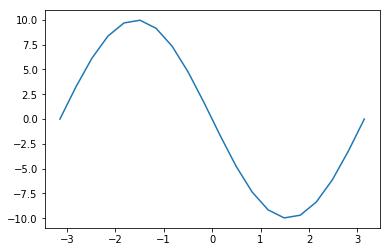

In [13]:
s = np.linspace(-np.pi, np.pi,20)
# sample sin negative wave
test_sinwave = -10*np.sin(s)
plt.plot(s,test_sinwave)

In [14]:
ans = sess.run(p,feed_dict={X:test_sinwave.reshape(1,20,1)})
idx = np.argmax(ans)
if idx == 0 :
    print("sin positive")
elif idx == 1 :
    print("sin negative")
elif idx == 2:
    print("cos positive")
elif idx == 3:
    print("cos negative")

sin negative


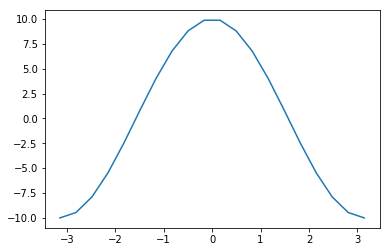

In [15]:
s = np.linspace(-np.pi, np.pi,20)
# sample cos positive wave
test_coswave = 10*np.cos(s)
plt.plot(s,test_coswave)